<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Description" data-toc-modified-id="Data-Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Description</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Useful-Functions" data-toc-modified-id="Useful-Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Useful Functions</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Train-test-split-with-stratify" data-toc-modified-id="Train-test-split-with-stratify-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train test split with stratify</a></span></li><li><span><a href="#Classification:-isolationForest" data-toc-modified-id="Classification:-isolationForest-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Classification: isolationForest</a></span></li><li><span><a href="#Classification:-LOF-(Local-Outlier-Factor)" data-toc-modified-id="Classification:-LOF-(Local-Outlier-Factor)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Classification: LOF (Local Outlier Factor)</a></span></li><li><span><a href="#Classification-Evaluation-Metrics" data-toc-modified-id="Classification-Evaluation-Metrics-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Classification Evaluation Metrics</a></span></li></ul></div>

<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel,  Data Scientist, Ph.D Astrophysics</a> .
</div>

# Data Description

The datasets contains transactions made by credit cards in September
2013 by european cardholders.


This dataset presents transactions that occurred in two days,
where we have 492 frauds out of 284,807 transactions. 

The dataset is highly unbalanced, the positive class (frauds)
account for 0.172% of all transactions.

It contains only numerical input variables which are
the result of a PCA transformation.


Unfortunately, due to confidentiality issues,
we cannot provide the original features and 
more background information about the data.


Features V1, V2, ... V28 are the principal
components obtained with PCA,
the only features which have not been transformed with PCA are 'Time' and 'Amount'. 

Feature 'Time' contains the seconds elapsed between each transaction
and the first transaction in the dataset. The feature 'Amount'
is the transaction Amount, this feature can be used for 
example-dependant cost-senstive learning. 

Feature 'Class' is the response variable and it takes value
1 in case of fraud and 0 otherwise.

# Imports

In [30]:
import bhishan
from bhishan import bp

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
import scikitplot as skplot

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time

import scipy
from scipy import stats

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scikitplot import metrics as skmetrics

# scale and split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# classifiers
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# random state
SEED=100
np.random.seed(random_state) # we need this in each cell

# Jupyter notebook settings for pandas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100) # None for all the rows
pd.set_option('display.max_colwidth', 50)

%load_ext watermark
%watermark -a "Bhishan Poudel" -d -v -m
%watermark -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Bhishan Poudel 2020-09-28 

CPython 3.7.7
IPython 7.18.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
scikitplot 0.3.7
sklearn    0.23.1
seaborn    0.11.0
pandas     1.1.0
matplotlib 3.2.1
autopep8   1.5.2
json       2.0.9
bhishan    0.3.1
scipy      1.4.1
numpy      1.18.4



# Useful Functions

In [64]:
def show_methods(obj, ncols=4):
    lst = [i for i in dir(obj) if i[0]!='_' ]
    df = pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')
    return df

# Load the data

In [16]:
df = pd.read_csv('../data/raw/creditcard.csv.zip',compression='zip')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Train test split with stratify

In [17]:
from sklearn.model_selection import train_test_split

target = 'Class'
Xtrain, Xtest, ytrain, ytest = train_test_split(
    df.drop(target,axis=1), df[target],
    test_size=0.2, random_state=random_state, stratify=df[target])

df.shape, Xtrain.shape, Xtest.shape

((284807, 31), (227845, 30), (56962, 30))

In [18]:
outlier_fraction = ytrain[ytrain==1].shape[0] /   ytrain[ytrain==0].shape[0]

# Classification: isolationForest

Reference:   
scikit learn  
https://scikit-learn.org/stable/modules/outlier_detection.html

One efficient way of performing outlier detection in high-dimensional datasets is to use random forests. The ensemble.IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

The implementation of ensemble.IsolationForest is based on an ensemble of tree.ExtraTreeRegressor. Following Isolation Forest original paper, the maximum depth of each tree is set to  where  is the number of samples used to build the tree (see (Liu et al., 2008) for more details).

This algorithm is illustrated below.
![](../images/isolation_forest_sklearn.png)

In [ ]:
%%time

clf_iso = IsolationForest(n_estimators=100,
                      max_samples=len(Xtrain),
                      n_jobs=-1,
                      contamination=outlier_fraction,
                      random_state=random_state,
                      verbose=1)


# fitting  
clf_iso.fit(Xtrain)

# prediction
scores_prediction = clf_iso.decision_function(Xtest)
ypreds = clf_iso.predict(Xtest)

# algorithm gives 1 and -1 classes, make them 0 and 1
ypreds[ypreds == 1] = 0
ypreds[ypreds == -1] = 1

ypreds_iso = ypreds

In [41]:
print(metrics.classification_report(ytest, ypreds_iso))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.26      0.29      0.27        98

    accuracy                           1.00     56962
   macro avg       0.63      0.64      0.64     56962
weighted avg       1.00      1.00      1.00     56962



In [42]:
df_eval = pd.DataFrame({
    'Model': [],
    'Description': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Weighted': [],
})

In [44]:
model_name = 'Isolation Forest'
desc = 'default'
sort_col = 'Recall'

acc = metrics.accuracy_score(ytest,ypreds_iso)
pre = metrics.precision_score(ytest,ypreds_iso)
rec = metrics.recall_score(ytest,ypreds_iso)
f1 = metrics.f1_score(ytest,ypreds_iso,average='weighted')

row = [ model_name,desc]
row = row + [acc, pre, rec, f1]
df_eval.loc[len(df_eval)] = row
df_eval = df_eval.drop_duplicates(subset=[ 'Model', 'Description'])
df_eval = df_eval.sort_values(sort_col,ascending=False)


display(df_eval.style.background_gradient(subset=[sort_col]))

,Model,Description,Accuracy,Precision,Recall,F1 Weighted
0,Isolation Forest,default,0.997384,0.261682,0.285714,0.997442


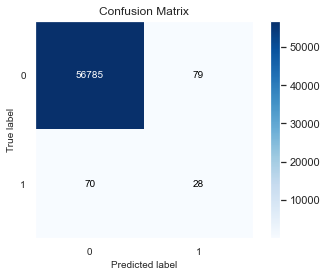

In [47]:
skmetrics.plot_confusion_matrix(ytest, ypreds_iso)

# Classification: LOF (Local Outlier Factor)

Reference: sklearn  

Unsupervised Outlier Detection using Local Outlier Factor (LOF)

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.

In [48]:
%%time

clf_lof = LocalOutlierFactor(n_neighbors=20,
                      algorithm='auto', 
                      leaf_size=30,
                      metric='minkowski',
                      p=2,
                      n_jobs=-1,
                      metric_params=None,
                      novelty=True,
                      contamination=outlier_fraction)

clf_lof.fit(Xtrain)
ypreds = clf_lof.predict(Xtest)

# alogrithm gives 1 and -1 classes, make them 0 and 1
ypreds[ypreds == 1] = 0
ypreds[ypreds == -1] = 1

ypreds_lof = ypreds

CPU times: user 11 s, sys: 223 ms, total: 11.3 s
Wall time: 4.34 s


In [49]:
print(metrics.classification_report(ytest, ypreds_lof))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.03      0.03      0.03        98

    accuracy                           1.00     56962
   macro avg       0.51      0.51      0.51     56962
weighted avg       1.00      1.00      1.00     56962



In [55]:
model_name = 'Local Outlier Factor'
desc = 'default'
sort_col = 'Recall'
ypreds = ypreds_lof

acc = metrics.accuracy_score(ytest,ypreds)
pre = metrics.precision_score(ytest,ypreds)
rec = metrics.recall_score(ytest,ypreds)
f1 = metrics.f1_score(ytest,ypreds,average='weighted')


row = [ model_name,desc]
row = row + [acc, pre, rec, f1]
df_eval.loc[len(df_eval)] = row
df_eval = df_eval.drop_duplicates(subset=[ 'Model', 'Description'])
df_eval = df_eval.sort_values(sort_col,ascending=False)


display(df_eval.style.background_gradient(subset=[sort_col]))

,Model,Description,Accuracy,Precision,Recall,F1 Weighted
0,Isolation Forest,default,0.997384,0.261682,0.285714,0.997442
1,Local Outlier Factor,default,0.996331,0.025641,0.030612,0.996493


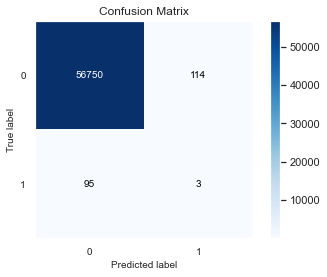

In [56]:
skmetrics.plot_confusion_matrix(ytest, ypreds_lof)

# Classification Evaluation Metrics
![](../images/classification_metrics.png)
![](../images/confusion_matrix.png)
![](../images/accuracy.png)
![](../images/precision.png)
![](../images/recall.png)
![](../images/f1_score.png)

In [66]:
show_methods(clf_iso)

,0,1,2,3
0,base_estimator,estimators_,max_samples,oob_score
1,base_estimator_,estimators_features_,max_samples_,predict
2,behaviour,estimators_samples_,n_estimators,random_state
3,bootstrap,fit,n_features_,score_samples
4,bootstrap_features,fit_predict,n_features_in_,set_params
5,contamination,get_params,n_jobs,verbose
6,decision_function,max_features,offset_,warm_start
7,estimator_params,,,


In [74]:
show_methods(clf_lof)

,0,1,2,3
0,algorithm,get_params,n_jobs,offset_
1,contamination,kneighbors,n_neighbors,p
2,decision_function,kneighbors_graph,n_neighbors_,predict
3,effective_metric_,leaf_size,n_samples_fit_,radius
4,effective_metric_params_,metric,negative_outlier_factor_,score_samples
5,fit,metric_params,novelty,set_params
6,fit_predict,n_features_in_,,


In [75]:
help(clf_iso.decision_function)

Help on method decision_function in module sklearn.ensemble._iforest:

decision_function(X) method of sklearn.ensemble._iforest.IsolationForest instance
    Average anomaly score of X of the base classifiers.
    
    The anomaly score of an input sample is computed as
    the mean anomaly score of the trees in the forest.
    
    The measure of normality of an observation given a tree is the depth
    of the leaf containing this observation, which is equivalent to
    the number of splittings required to isolate this point. In case of
    several observations n_left in the leaf, the average path length of
    a n_left samples isolation tree is added.
    
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        The input samples. Internally, it will be converted to
        ``dtype=np.float32`` and if a sparse matrix is provided
        to a sparse ``csr_matrix``.
    
    Returns
    -------
    scores : ndarray of shape (n_samples,)


In [78]:
yprobs_iso = clf_iso.decision_function(Xtest)
yprobs_iso.shape, yprobs_iso[:10]

((56962,),
 array([0.17929489, 0.18313638, 0.17685782, 0.18223546, 0.19401706,
        0.1876981 , 0.19039054, 0.17579801, 0.18324446, 0.17319798]))

In [79]:
yprobs_lof = clf_lof.decision_function(Xtest)
yprobs_lof.shape

(56962,)

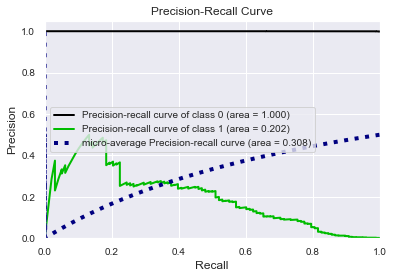

In [82]:
skmetrics.plot_precision_recall(ytest, np.c_[yprobs_iso, 1 - yprobs_iso])

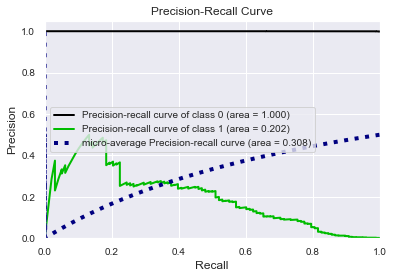

In [81]:
skmetrics.plot_precision_recall(ytest, np.c_[yprobs_iso, 1 - yprobs_iso])